In [1]:
import pandas as pd
import torch
from torch.nn import CrossEntropyLoss, MSELoss
from torch.optim import AdamW
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score

In [2]:
# Load the data
df_train = pd.read_csv('dataset/tweets_train.csv')

# Load the BERT tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-large')

# Tokenize the tweets for regression
input_sequences_regression = tokenizer(df_train['text'].tolist(), truncation=True, padding=True, max_length=128, return_tensors="pt")

# Tokenize the tweets for classification (and convert sentiments to categorical format)
sentiment_map = {'positive': 2, 'neutral': 1, 'negative': 0}
df_train['sentiment_category'] = df_train['sentiment'].map(sentiment_map)
labels_classification = torch.tensor(df_train['sentiment_category'].values)
input_sequences_classification = tokenizer(df_train['text'].tolist(), truncation=True, padding=True, max_length=128, return_tensors="pt")

# Split the data into training and validation sets for both regression and classification
train_inputs_regression, val_inputs_regression, train_labels_regression, val_labels_regression = train_test_split(input_sequences_regression['input_ids'], df_train['score_compound'].values, test_size=0.2, random_state=42)
train_inputs_classification, val_inputs_classification, train_labels_classification, val_labels_classification = train_test_split(input_sequences_classification['input_ids'], labels_classification, test_size=0.2, random_state=42)


In [3]:
# Create DataLoader for efficient mini-batch training for regression
train_dataset_regression = TensorDataset(train_inputs_regression.to('cuda'), torch.tensor(train_labels_regression).to('cuda'))
train_loader_regression = DataLoader(train_dataset_regression, batch_size=32, shuffle=True)

val_dataset_regression = TensorDataset(val_inputs_regression.to('cuda'), torch.tensor(val_labels_regression).to('cuda'))
val_loader_regression = DataLoader(val_dataset_regression, batch_size=32, shuffle=False)

# For classification
train_dataset_classification = TensorDataset(train_inputs_classification.to('cuda'), train_labels_classification.to('cuda'))
train_loader_classification = DataLoader(train_dataset_classification, batch_size=32, shuffle=True)

val_dataset_classification = TensorDataset(val_inputs_classification.to('cuda'), val_labels_classification.to('cuda'))
val_loader_classification = DataLoader(val_dataset_classification, batch_size=32, shuffle=False)


**Regression**

In [4]:
# Initialize the BERT model for regression
model_regression = RobertaForSequenceClassification.from_pretrained('roberta-large', num_labels=1)
model_regression = model_regression.to('cuda')  # Move to GPU, if available

# Loss, Optimizer, and Learning Rate Scheduler
loss_fn = MSELoss()
optimizer = AdamW(model_regression.parameters(), lr=3e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader_regression)*3)  # Assuming 3 epochs

# Lists to store losses and metrics
train_losses = []
val_losses = []

# Training loop
for epoch in range(4):
    model_regression.train()
    train_loss = 0
    for batch in train_loader_regression:
        optimizer.zero_grad()
        inputs, targets = batch
        outputs = model_regression(inputs).logits.squeeze()
        loss = loss_fn(outputs, targets.float())
        loss.backward()
        optimizer.step()
        scheduler.step()
        train_loss += loss.item()
    
    # Calculate average training loss
    avg_train_loss = train_loss / len(train_loader_regression)
    train_losses.append(avg_train_loss)
    
    # Validation
    model_regression.eval()
    sum_squared_errors = 0
    total_instances = 0
    with torch.no_grad():
        for batch in val_loader_regression:
            inputs, targets = batch
            outputs = model_regression(inputs).logits.squeeze()
            squared_errors = (outputs - targets.float()) ** 2
            sum_squared_errors += torch.sum(squared_errors).item()
            total_instances += targets.size(0)
    
    # Calculate average validation loss (MSE)
    avg_val_loss = sum_squared_errors / total_instances
    val_losses.append(avg_val_loss)
    
    # Calculate RMSE for regression
    val_rmse = torch.sqrt(torch.tensor(avg_val_loss))
    
    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    print(f"Validation RMSE for Regression: {val_rmse:.4f}")



Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
You should 

Epoch 1 | Train Loss: 0.2341 | Val Loss: 0.1961
Validation RMSE for Regression: 0.4429
Epoch 2 | Train Loss: 0.2240 | Val Loss: 0.1939
Validation RMSE for Regression: 0.4404
Epoch 3 | Train Loss: 0.2044 | Val Loss: 0.1456
Validation RMSE for Regression: 0.3815
Epoch 4 | Train Loss: 0.1677 | Val Loss: 0.1456
Validation RMSE for Regression: 0.3815


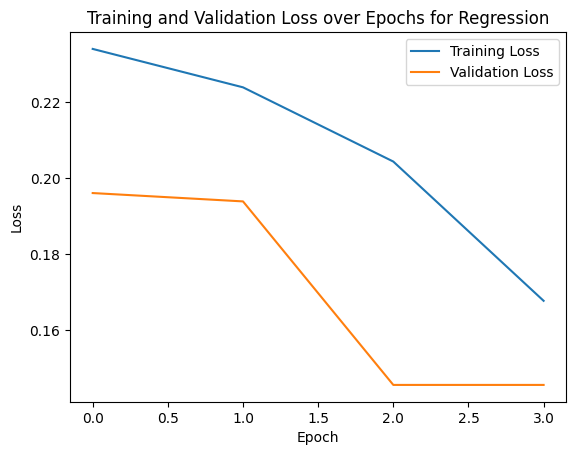

In [5]:
# Plot training and validation loss for regression
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs for Regression')
plt.legend()
plt.show()


In [6]:
df_test_1 = pd.read_csv('dataset/tweets_test_1.csv')
df_test_2 = pd.read_csv('dataset/tweets_test_2.csv')

In [7]:
# Tokenize test datasets
test_sequences_1_regression = tokenizer(df_test_1['text'].tolist(), truncation=True, padding=True, max_length=128, return_tensors="pt")
test_sequences_2_regression = tokenizer(df_test_2['text'].tolist(), truncation=True, padding=True, max_length=128, return_tensors="pt")

test_sequences_1_classification = tokenizer(df_test_1['text'].tolist(), truncation=True, padding=True, max_length=128, return_tensors="pt")
test_sequences_2_classification = tokenizer(df_test_2['text'].tolist(), truncation=True, padding=True, max_length=128, return_tensors="pt")


In [8]:
# Predict with the regression model
model_regression.eval()
with torch.no_grad():
    predictions_test_1_regression = model_regression(test_sequences_1_regression['input_ids'].to('cuda')).logits.squeeze().cpu().numpy()
    predictions_test_2_regression = model_regression(test_sequences_2_regression['input_ids'].to('cuda')).logits.squeeze().cpu().numpy()


In [9]:
import os
import numpy as np

# Assuming team_id and split are defined as per the solution_notebook
team_id = "20"  # Replace 'your_team_id' with your actual team ID
split = "test_1"  # This is for df_test_1

# Save the regression predictions
directory = 'results'
if not os.path.exists(directory):
    os.makedirs(directory)
np.save(os.path.join(directory, f'{team_id}__{split}__reg_pred.npy'), predictions_test_1_regression)

In [10]:
split = "test_2"  # This is for df_test_2

np.save(os.path.join(directory, f'{team_id}__{split}__reg_pred.npy'), predictions_test_2_regression)

**Classification**

In [20]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW

from transformers import RobertaConfig

config = RobertaConfig.from_pretrained('roberta-large', num_labels=3)
model_classification = RobertaForSequenceClassification.from_pretrained('roberta-large', config=config).to('cuda')

# Define the optimizer (same as before)
optimizer_classification = AdamW(model_classification.parameters(), lr=3e-5, eps=1e-8)

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
You should 

In [21]:
from transformers import get_linear_schedule_with_warmup

# Define the DataLoader for the classification task
train_dataset_classification = TensorDataset(train_inputs_classification, train_labels_classification)
train_loader_classification = DataLoader(train_dataset_classification, batch_size=32, shuffle=True)

val_dataset_classification = TensorDataset(val_inputs_classification, val_labels_classification)
val_loader_classification = DataLoader(val_dataset_classification, batch_size=32, shuffle=False)


# Training loop with both training and validation phases
epochs = 4
total_steps = len(train_loader_classification) * epochs
scheduler_classification = get_linear_schedule_with_warmup(optimizer_classification, num_warmup_steps=0, num_training_steps=total_steps)

# Lists to store loss values
train_loss_values = []
validation_loss_values = []

# Loss function for classification
loss_fn = CrossEntropyLoss()

for epoch in range(epochs):
    # Training phase
    model_classification.train()
    total_train_loss = 0
    for batch in train_loader_classification:
        b_input_ids, b_labels = batch[0].to('cuda'), batch[1].to('cuda')  # Ensure tensors are on GPU
        model_classification.zero_grad()
        outputs = model_classification(b_input_ids).logits
        loss = loss_fn(outputs, b_labels)
        total_train_loss += loss.item()
        loss.backward()
        optimizer_classification.step()
        scheduler_classification.step()
    avg_train_loss = total_train_loss / len(train_loader_classification)
    train_loss_values.append(avg_train_loss)
    
    # Validation phase
    model_classification.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in val_loader_classification:
            b_input_ids, b_labels = batch[0].to('cuda'), batch[1].to('cuda')
            outputs = model_classification(b_input_ids).logits
            loss = loss_fn(outputs, b_labels)
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss / len(val_loader_classification)
    validation_loss_values.append(avg_val_loss)
    # Predict and compute metrics on validation data
    model_classification.eval()
    val_predictions = []
    val_true = []
    with torch.no_grad():
        for batch in val_loader_classification:
            b_input_ids, b_labels = batch[0].to('cuda'), batch[1].to('cuda')
            logits = model_classification(b_input_ids).logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            val_predictions.extend(preds)
            val_true.extend(b_labels.cpu().numpy())
    
    val_accuracy = accuracy_score(val_true, val_predictions)
    val_f1 = f1_score(val_true, val_predictions, average='weighted')
    
    print(f"Validation Accuracy for Classification: {val_accuracy:.4f}")
    print(f"Validation F1 Score for Classification: {val_f1:.4f}")
    
    # Print training and validation results for the epoch
    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

Validation Accuracy for Classification: 0.6813
Validation F1 Score for Classification: 0.5521
Epoch 1 | Train Loss: 0.8309 | Val Loss: 0.7674
Validation Accuracy for Classification: 0.6813
Validation F1 Score for Classification: 0.5521
Epoch 2 | Train Loss: 0.8182 | Val Loss: 0.7772
Validation Accuracy for Classification: 0.6813
Validation F1 Score for Classification: 0.5521
Epoch 3 | Train Loss: 0.8164 | Val Loss: 0.7715
Validation Accuracy for Classification: 0.6813
Validation F1 Score for Classification: 0.5521
Epoch 4 | Train Loss: 0.8106 | Val Loss: 0.7751


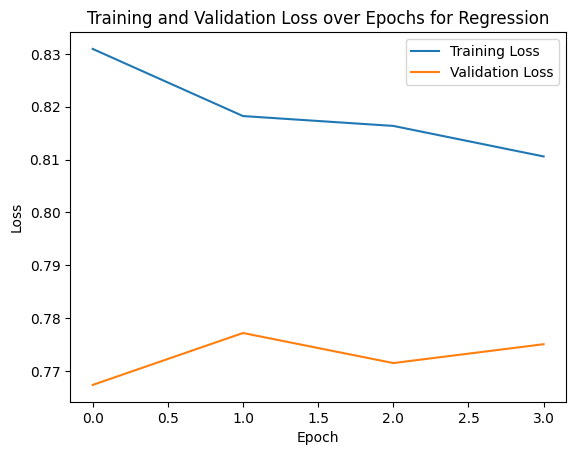

In [22]:
# Plot same like regression task
# Plot training and validation loss for regression
plt.plot(train_loss_values, label='Training Loss')
plt.plot(validation_loss_values, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs for Regression')
plt.legend()
plt.show()


In [23]:
# Predict on test data using classification model
model_classification.eval()
with torch.no_grad():
    predictions_test_1_classification = model_classification(test_sequences_1_classification['input_ids'].to('cuda')).logits.squeeze().cpu().numpy()
    predictions_test_2_classificaiton = model_classification(test_sequences_2_classification['input_ids'].to('cuda')).logits.squeeze().cpu().numpy()

In [ ]:
# Convert logits to class labels for test set 1
class_predictions_test_1 = np.argmax(predictions_test_1_classification, axis=1)

# Convert logits to class labels for test set 2
class_predictions_test_2 = np.argmax(predictions_test_2_classificaiton, axis=1)


In [ ]:
reverse_sentiment_map = {2: 'positive', 1: 'neutral', 0: 'negative'}
# Convert numeric predictions to string labels for test set 1
class_predictions_test_1_labels = [reverse_sentiment_map[pred] for pred in class_predictions_test_1]

# Convert numeric predictions to string labels for test set 2
class_predictions_test_2_labels = [reverse_sentiment_map[pred] for pred in class_predictions_test_2]


In [ ]:
split = "test_1"
# Save for test set 1
np.save(os.path.join('results', f'{team_id}__{split}__clf_pred.npy'), class_predictions_test_1_labels)

In [ ]:
split = "test_2"
# Save for test set 2
np.save(os.path.join('results', f'{team_id}__{split}__clf_pred.npy'), class_predictions_test_2_labels)